<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1">Goal</a></span></li><li><span><a href="#Spectrograms" data-toc-modified-id="Spectrograms-2">Spectrograms</a></span><ul class="toc-item"><li><span><a href="#Waveform" data-toc-modified-id="Waveform-2.1">Waveform</a></span></li><li><span><a href="#Mel-spectrogram" data-toc-modified-id="Mel-spectrogram-2.2">Mel spectrogram</a></span></li></ul></li><li><span><a href="#Tensorflow-Protobuf" data-toc-modified-id="Tensorflow-Protobuf-3">Tensorflow Protobuf</a></span></li><li><span><a href="#Spectrograms-to-TFRecord" data-toc-modified-id="Spectrograms-to-TFRecord-4">Spectrograms to TFRecord</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## Goal

Convert data to **TFRecord** format.

The raw data is stored in WAV files and we need to convert it to a format that can be easily used for model training. First step is to transform audio records to multi-dimensional arrays. One way to do this is to calculate mel spectrogram. Second step is to represent arrays and other features as protobufs

In [2]:
METADATA_FILE = 'meta_data.csv'
TFR_FILE = 'spectorgrams.tfrecord'

In [3]:
import pandas as pd

meta_data = pd.read_csv(METADATA_FILE)
meta_data.sample(3)

,emotion,intensity,statement,repetition,actor,actor_name,file_name
341,happy,normal,2,1,female,actor_19,data/Actor_19/03-01-03-01-02-01-19.wav
843,disgust,normal,2,1,female,actor_23,data/Actor_23/03-01-07-01-02-01-23.wav
53,surprised,normal,2,1,male,actor_16,data/Actor_16/03-01-08-01-02-01-16.wav


## Spectrograms

### Waveform

Simples way to represent signals is a waveform, a time series - amplitude as a function of time:

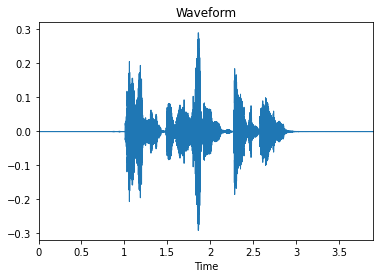

In [5]:
import librosa
import librosa.display

audio, sr = librosa.load(meta_data.iloc[0].file_name)

plt.title('Waveform')
librosa.display.waveplot(audio);

### Mel spectrogram

Spectrogram is a visualization of spectrum over time. Spectrum is calculated from an output of Fourier Transform.

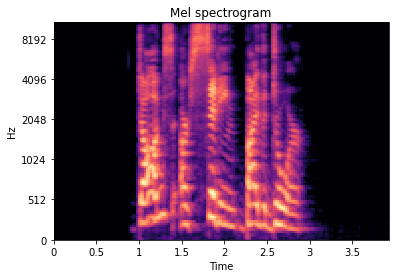

In [6]:
mel_spect = librosa.feature.melspectrogram(y=audio, sr=sr)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.title('Mel spectrogram')
librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time');

## Tensorflow Protobuf

https://www.tensorflow.org/tutorials/load_data/tfrecord

Create instances of **tf.train.Example** and write them to a file in **TFRecord** format. Each message is a map `{"key": value}` when value is a feature that contains, for example `tf.train.BytesList`.

In [7]:
import tensorflow as tf
import numpy as np


def create_text_feature(text: str):
    """Convert strings to tf.train.BytesList"""
    return tf.train.Feature(bytes_list=tf.train.BytesList(
        value=[text.encode('utf-8')]))


def crete_numpy_feature(array: np.array):
    """Convert numpy array to tf.train.BytesList"""
    array = tf.io.serialize_tensor(array).numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[array]))


def create_features(emotion: str, intensity: str, actor: str,
                    mel_spect: np.array):
    return tf.train.Features(
        feature={
            'emotion': create_text_feature(emotion),
            'intensity': create_text_feature(intensity),
            'actor': create_text_feature(actor),
            'mel_spect': crete_numpy_feature(mel_spect)
        })


def create_serialized_msg(emotion: str, intensity: str, actor: str,
                              mel_spect: np.array):
    """Create tf.train.Example and convert it to a string"""
    example = tf.train.Example(
        features=create_features(emotion, intensity, actor, mel_spect))

    return example.SerializeToString()

## Spectrograms to TFRecord

In [ ]:
from tqdm.notebook import tqdm

with tf.io.TFRecordWriter(TFR_FILE) as trf_writer:
    
    with tqdm(total=meta_data.shape[0]) as pbar:
        
        for item in meta_data.itertuples():

            y, sr = librosa.load(item.file_name)
            mel_spect = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

            example_msg = create_serialized_msg(item.emotion, item.intensity, item.actor, mel_spect)

            trf_writer.write(example_msg)
            
            pbar.update(1)